# Baseline Models

This notebook trains and evaluates baseline models (LSTM, CNN, BiLSTM+Attention).

## Objectives
- Train baseline models on IMDB dataset
- Compare model performance
- Visualize training progress
- Analyze errors


In [11]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from pathlib import Path

from src.data.dataset_loader import load_preprocessed_data
from src.data.preprocess import clean_text, create_vocabulary
from src.models.lstm_model import LSTMModel, BiLSTMWithAttention
from src.models.cnn_model import CNNModel
from src.utils.seed_everything import seed_everything
from src.utils.config_loader import load_config

seed_everything(42)
config = load_config('../config.yaml')


## 1. Load and Prepare Data


In [12]:
# Load preprocessed IMDB data (from notebook 02) - already split into train/val/test
from src.data.dataset_loader import load_preprocessed_data

print("Loading preprocessed IMDB data (train/val/test splits)...")
train_texts, train_labels = load_preprocessed_data('imdb_train', data_dir='../intermediate/data')
val_texts, val_labels = load_preprocessed_data('imdb_val', data_dir='../intermediate/data')
test_texts, test_labels = load_preprocessed_data('imdb_test', data_dir='../intermediate/data')

print(f"✅ Loaded preprocessed data (already split)")
print(f"Train: {len(train_texts)}, Val: {len(val_texts)}, Test: {len(test_texts)}")


Loading preprocessed IMDB data (train/val/test splits)...
✅ Loaded preprocessed data (already split)
Train: 35000, Val: 5000, Test: 10000


## 2. Create Vocabulary

Note: Vocabulary creation uses the cleaned/preprocessed texts from the previous step. This vocabulary will be used for all baseline models (LSTM, CNN, etc.).


In [13]:
# Create vocabulary for baseline models
# Use all training data to build comprehensive vocabulary
print("Creating vocabulary from training data...")
vocab = create_vocabulary(train_texts, min_freq=2)
vocab_size = len(vocab)
print(f"✅ Vocabulary size: {vocab_size}")
print(f"Sample vocabulary entries: {list(vocab.items())[:5]}")


Creating vocabulary from training data...
✅ Vocabulary size: 101105
Sample vocabulary entries: [('the', 2), ('a', 3), ('and', 4), ('of', 5), ('to', 6)]


## 3. Train LSTM Model

Using preprocessed data and vocabulary - ready to train!


In [14]:
# Prepare data for baseline models (convert to sequences of word indices)
# Set device: MPS (Metal) for Apple Silicon, CUDA for NVIDIA, else CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("⚠️ Using CPU (no GPU available)")
print(f"Device: {device}")

# Initialize LSTM model
lstm_model = LSTMModel(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    num_layers=2,
    num_classes=2,
    dropout=0.2
).to(device)

print(f"✅ LSTM Model initialized")
print(f"Model parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")


✅ Using Apple Silicon GPU (MPS)
Device: mps
✅ LSTM Model initialized
Model parameters: 10,741,798


### 3.1 Create Dataset and DataLoader

We need to convert text to sequences of word indices using our vocabulary.


In [15]:
# Create a PyTorch Dataset for baseline models
from torch.utils.data import Dataset, DataLoader

class BaselineSentimentDataset(Dataset):
    """Dataset for baseline models that uses word-level vocabulary."""
    
    def __init__(self, texts, labels, vocab, max_length=256):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length
        self.unk_idx = vocab.get('<UNK>', 1)
        self.pad_idx = vocab.get('<PAD>', 0)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize: convert words to indices
        words = text.lower().split()
        sequence = []
        for word in words:
            sequence.append(self.vocab.get(word, self.unk_idx))
        
        # Pad or truncate to max_length
        if len(sequence) < self.max_length:
            sequence = sequence + [self.pad_idx] * (self.max_length - len(sequence))
        else:
            sequence = sequence[:self.max_length]
        
        return {
            'input_ids': torch.tensor(sequence, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
print("Creating datasets...")
train_dataset = BaselineSentimentDataset(train_texts, train_labels, vocab, max_length=256)
val_dataset = BaselineSentimentDataset(val_texts, val_labels, vocab, max_length=256)
test_dataset = BaselineSentimentDataset(test_texts, test_labels, vocab, max_length=256)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Datasets created: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
print(f"Batch size: {batch_size}")


Creating datasets...
✅ Datasets created: Train=35000, Val=5000, Test=10000
Batch size: 32


### 3.2 Training Setup

Set up optimizer, loss function, and training parameters.

**Note on Epochs:**
- Baseline models (LSTM, CNN) typically need **15-20 epochs** to converge
- Transformers (BERT, etc.) usually only need **3-5 epochs** because:
  - They're pre-trained and fine-tune quickly
  - They have more parameters and learn faster
  - Longer training risks overfitting
  
- We'll use **20 epochs with early stopping** to:
  - Allow the model time to learn
  - Prevent overfitting by stopping when validation performance plateaus


In [16]:
# Setup training components
from torch.optim import Adam
from tqdm import tqdm
import time

optimizer = Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training parameters
# Note: Baseline LSTM models typically need 15-20 epochs to converge
# (vs 3-5 epochs for transformers which train faster)
num_epochs = 20
patience = 5  # Early stopping patience (stop if no improvement for N epochs)
min_delta = 0.0001  # Minimum improvement to consider

print(f"Training parameters:")
print(f"  Epochs: {num_epochs} (baseline models need more epochs than transformers)")
print(f"  Early stopping patience: {patience} epochs")
print(f"  Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"  Batch size: {batch_size}")
print(f"  Device: {device}")


Training parameters:
  Epochs: 20 (baseline models need more epochs than transformers)
  Early stopping patience: 5 epochs
  Learning rate: 0.001
  Batch size: 32
  Device: mps


### 3.3 Training Loop

Train the LSTM model with validation monitoring.


In [17]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_val_loss = float('inf')
patience_counter = 0
early_stopped = False

print("Starting training...")
print("Note: Baseline models (LSTM/CNN) typically need 15-20 epochs vs 3-5 for transformers\n")

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training phase
    lstm_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for batch in train_pbar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = lstm_model(input_ids)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
        
        # Update progress bar
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{train_correct/train_total:.4f}'
        })
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    lstm_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        for batch in val_pbar:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = lstm_model(input_ids)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{val_correct/val_total:.4f}'
            })
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # Update history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    
    # Early stopping check
    # Check if we improved (either accuracy or loss)
    improved = False
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        improved = True
        # Could save model here: torch.save(lstm_model.state_dict(), 'best_lstm_model.pth')
    
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        improved = True
    
    # Reset patience counter if we improved (on either metric), otherwise increment
    if improved:
        patience_counter = 0
    else:
        patience_counter += 1
    
    elapsed_time = time.time() - start_time
    
    print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"  Best Val Acc: {best_val_acc:.4f} | Best Val Loss: {best_val_loss:.4f}")
    print(f"  Time: {elapsed_time:.2f}s")
    
    if patience_counter >= patience:
        early_stopped = True
        print(f"\n⚠️ Early stopping triggered! No improvement for {patience} epochs.")
        print(f"Stopping training at epoch {epoch+1}")
        break
    
    print()

if not early_stopped:
    print("✅ Training complete! Reached maximum epochs.")
else:
    print(f"✅ Training stopped early at epoch {epoch+1} (best val acc: {best_val_acc:.4f})")


Starting training...
Note: Baseline models (LSTM/CNN) typically need 15-20 epochs vs 3-5 for transformers



Epoch 1/20 [Val]: 100%|██████████| 157/157 [00:05<00:00, 28.75it/s, loss=0.7656, acc=0.6950]



Epoch 1/20 Summary:
  Train Loss: 0.6402 | Train Acc: 0.6257
  Val Loss: 0.6193 | Val Acc: 0.6950
  Best Val Acc: 0.6950 | Best Val Loss: 97.2292
  Time: 119.35s



Epoch 2/20 [Val]: 100%|██████████| 157/157 [00:05<00:00, 29.23it/s, loss=1.0893, acc=0.8276]



Epoch 2/20 Summary:
  Train Loss: 0.4337 | Train Acc: 0.8009
  Val Loss: 0.4063 | Val Acc: 0.8276
  Best Val Acc: 0.8276 | Best Val Loss: 63.7867
  Time: 117.71s



Epoch 3/20 [Val]: 100%|██████████| 157/157 [00:05<00:00, 29.48it/s, loss=0.7157, acc=0.8510]



Epoch 3/20 Summary:
  Train Loss: 0.2841 | Train Acc: 0.8867
  Val Loss: 0.3482 | Val Acc: 0.8510
  Best Val Acc: 0.8510 | Best Val Loss: 54.6670
  Time: 126.42s



Epoch 4/20 [Val]: 100%|██████████| 157/157 [00:06<00:00, 25.74it/s, loss=1.1403, acc=0.8744]



Epoch 4/20 Summary:
  Train Loss: 0.1945 | Train Acc: 0.9279
  Val Loss: 0.3371 | Val Acc: 0.8744
  Best Val Acc: 0.8744 | Best Val Loss: 52.9186
  Time: 129.16s



Epoch 5/20 [Val]: 100%|██████████| 157/157 [00:04<00:00, 31.53it/s, loss=1.0238, acc=0.8780]



Epoch 5/20 Summary:
  Train Loss: 0.1242 | Train Acc: 0.9569
  Val Loss: 0.3793 | Val Acc: 0.8780
  Best Val Acc: 0.8780 | Best Val Loss: 52.9186
  Time: 125.11s



Epoch 6/20 [Val]: 100%|██████████| 157/157 [00:05<00:00, 29.57it/s, loss=1.6870, acc=0.8632]



Epoch 6/20 Summary:
  Train Loss: 0.0755 | Train Acc: 0.9750
  Val Loss: 0.4778 | Val Acc: 0.8632
  Best Val Acc: 0.8780 | Best Val Loss: 52.9186
  Time: 121.32s



Epoch 7/20 [Val]: 100%|██████████| 157/157 [00:05<00:00, 27.68it/s, loss=2.0580, acc=0.8706]



Epoch 7/20 Summary:
  Train Loss: 0.0435 | Train Acc: 0.9861
  Val Loss: 0.5316 | Val Acc: 0.8706
  Best Val Acc: 0.8780 | Best Val Loss: 52.9186
  Time: 126.37s



Epoch 8/20 [Val]: 100%|██████████| 157/157 [00:05<00:00, 28.09it/s, loss=1.2966, acc=0.8736]



Epoch 8/20 Summary:
  Train Loss: 0.0302 | Train Acc: 0.9909
  Val Loss: 0.5844 | Val Acc: 0.8736
  Best Val Acc: 0.8780 | Best Val Loss: 52.9186
  Time: 121.09s



Epoch 9/20 [Val]: 100%|██████████| 157/157 [00:04<00:00, 31.78it/s, loss=3.4938, acc=0.8582]



Epoch 9/20 Summary:
  Train Loss: 0.0241 | Train Acc: 0.9928
  Val Loss: 0.7042 | Val Acc: 0.8582
  Best Val Acc: 0.8780 | Best Val Loss: 52.9186
  Time: 117.76s



Epoch 10/20 [Val]: 100%|██████████| 157/157 [00:04<00:00, 31.56it/s, loss=2.4438, acc=0.8722]



Epoch 10/20 Summary:
  Train Loss: 0.0143 | Train Acc: 0.9958
  Val Loss: 0.6362 | Val Acc: 0.8722
  Best Val Acc: 0.8780 | Best Val Loss: 52.9186
  Time: 113.33s

⚠️ Early stopping triggered! No improvement for 5 epochs.
Stopping training at epoch 10
✅ Training stopped early at epoch 10 (best val acc: 0.8780)


### 3.4 Evaluate on Test Set

Evaluate the trained model on the test set.


In [20]:
# Evaluate on test set
lstm_model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    test_pbar = tqdm(test_loader, desc="Evaluating on test set")
    for batch in test_pbar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = lstm_model(input_ids)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        test_correct += (predictions == labels).sum().item()
        test_total += labels.size(0)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_acc = test_correct / test_total

print(f"\n📊 Test Set Results:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f} ({test_correct}/{test_total})")

# Calculate additional metrics
from sklearn.metrics import classification_report, confusion_matrix
print(f"\n📈 Detailed Metrics:")
print(classification_report(all_labels, all_predictions, target_names=['Negative', 'Positive']))


Evaluating on test set: 100%|██████████| 313/313 [00:11<00:00, 27.31it/s]


📊 Test Set Results:
  Test Loss: 0.6345
  Test Accuracy: 0.8678 (8678/10000)

📈 Detailed Metrics:
              precision    recall  f1-score   support

    Negative       0.86      0.89      0.87      5000
    Positive       0.88      0.85      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



### 3.5 Visualize Training History

Plot training curves to see how the model learned.


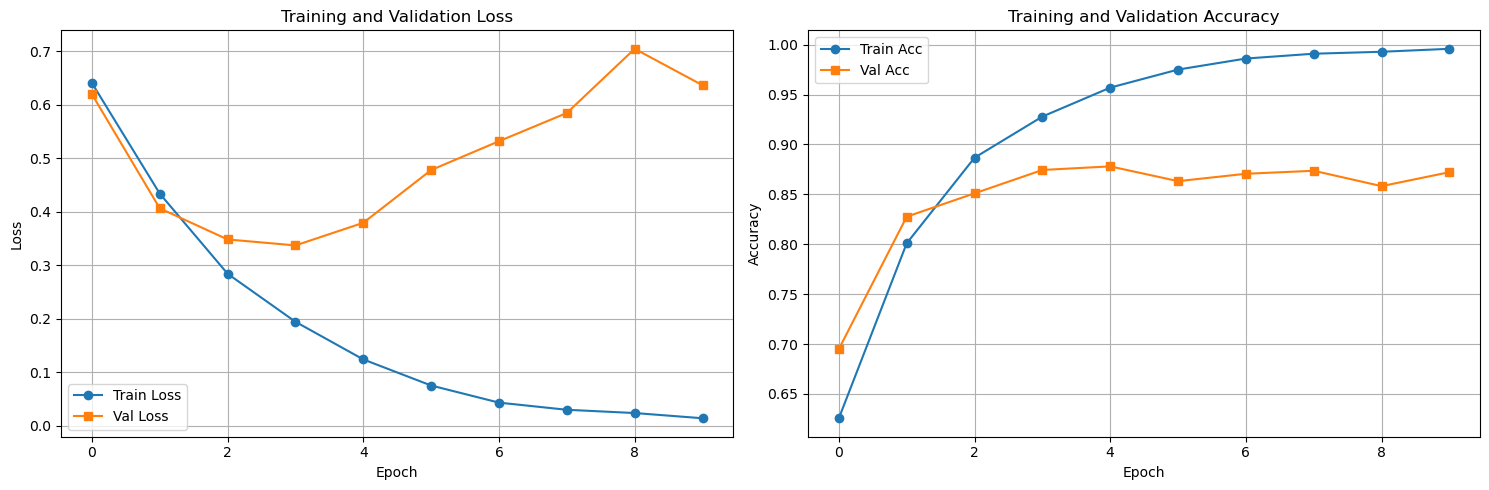

✅ Training plots saved to ../experiments/plots/lstm_training_history.png


In [21]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../experiments/plots/lstm_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Training plots saved to ../experiments/plots/lstm_training_history.png")
